In [1]:
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Embedding, regularizers
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.merge import Concatenate
from keras import optimizers
from keras.preprocessing import sequence
from keras import backend as K
from w2v import train_word2vec 
import pickle, datetime
import numpy as np
import difflib
from keras.datasets import imdb

Using TensorFlow backend.


# ------------------------------- Data Preprocessing -----------------------------------

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
max_words = 5000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words, start_char=None)

N_TRAIN = x_train.shape[0] 
N_TEST = x_test.shape[0]

In [4]:
max_sent_len = -1
for sent in x_train:
    max_sent_len = max(max_sent_len, len(sent))

for sent in x_test:
    max_sent_len = max(max_sent_len, len(sent))

print(max_sent_len)
max_sent_len = 400

2493


In [5]:
x_train = sequence.pad_sequences(x_train, maxlen=max_sent_len, padding="post", truncating="post")
x_test = sequence.pad_sequences(x_test, maxlen=max_sent_len, padding="post", truncating="post")

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

vocabulary = imdb.get_word_index()
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "<PAD/>"

x_train shape: (25000, 400)
x_test shape: (25000, 400)


# -------------------------------- Training model  -----------------------------------

### Model Paremeters

In [6]:
model_type    = 'CNN-rand'  # CNN-rand|CNN-non-static|CNN-static
embedding_dim = 100         # word2vec dim
vocab_size    = len(vocabulary_inv)
N_category    = 2

### Generate word2vec 

In [7]:
if model_type in ['CNN-non-static', 'CNN-static']:
    embedding_wts = train_word2vec( np.vstack((x_train, x_test)), 
                                    vocabulary_inv, num_features = embedding_dim)
    if model_type == 'CNN-static':
        x_train = embedding_wts[0][x_train]
        x_test  = embedding_wts[0][x_test]
#         x_valid = embedding_wts[0][x_valid]
        
elif model_type == 'CNN-rand':
    embedding_wts = None
    
else:
    raise ValueError("Unknown model type")

### Create model

In [8]:
filter_sizes = [3,4,5]
num_filters  = 50
dropout_prob = (0.5, 0.8)
hidden_dims  = 50
batch_size   = 64
l2_reg = 0.3

# Deciding dimension of input based on the model
input_shape = (max_sent_len, embedding_dim) if model_type == "CNN-static" else (max_sent_len,)
model_input = Input(shape = input_shape)

# Static model do not have embedding layer
if model_type == "CNN-static":
    z = Dropout(dropout_prob[0])(model_input)
else:
    z = Embedding(vocab_size, embedding_dim, input_length = max_sent_len, name="embedding", trainable=True)(model_input)
    z = Dropout(dropout_prob[0])(z)

# Convolution layers
z1 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[0], 
                padding="valid", activation="relu", 
                strides=1)(z)
z1 = MaxPooling1D(pool_size = max_sent_len - filter_sizes[0] + 1)(z1)
z1 = Flatten()(z1)

z2 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[1], 
                padding="valid", activation="relu", 
                strides=1)(z)
z2 = MaxPooling1D(pool_size=max_sent_len - filter_sizes[1] + 1)(z2)
z2 = Flatten()(z2)

z3 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[2], 
                padding="valid", activation="relu",
                strides=1)(z)
z3 = MaxPooling1D(pool_size=max_sent_len - filter_sizes[2] + 1)(z3)
z3 = Flatten()(z3)

# Concatenate the output of all convolution layers
z = Concatenate()([z1, z2, z3])
z = Dropout(dropout_prob[1])(z)

z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)
    
model = Model(model_input, model_output)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 400)           0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 400, 100)      8858500                                      
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 400, 100)      0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 398, 50)       15050                                        
___________________________________________________________________________________________

### Train model 

In [10]:
# from sklearn.metrics import roc_auc_score
import time
import pylab as pl
from IPython import display
pl.style.use('ggplot')
%matplotlib inline

class Histories(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_loss = []
        self.val_acc = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs['acc'])
        self.loss.append(logs['loss'])
        self.val_acc.append(logs['val_acc'])
        self.val_loss.append(logs['val_loss'])
        
        pl.hold(True)
        pl.plot(self.acc)
        pl.plot(self.loss)
        pl.plot(self.val_acc)
        pl.plot(self.val_loss)
        pl.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

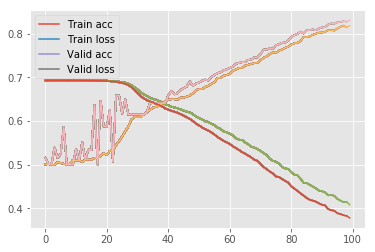

9s - loss: 0.4081 - acc: 0.8179 - val_loss: 0.3779 - val_acc: 0.8306


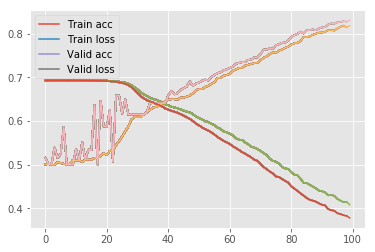

In [11]:
if model_type == "CNN-non-static":
    embedding_layer = model.get_layer("embedding")
    embedding_layer.set_weights(embedding_wts)

model.compile(loss="binary_crossentropy", optimizer=optimizers.SGD(), metrics=["accuracy"])
histories = Histories()
res = model.fit(x_train, y_train,
          batch_size = batch_size,
          epochs=100,
          validation_data=(x_test, y_test), verbose=2, callbacks=[histories])

In [ ]:
import os
os.system('say done')

### Computing Accuracy

In [12]:
# Final evaluation of the model
scores = model.evaluate(x_train, y_train, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 84.11%
Accuracy: 83.06%


### Save the model

In [15]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = './reorg_' + model_type + '_' + date + '_' +time

with open( filename + '_history', 'wb') as output:
    pickle.dump([model.history.history], output, pickle.HIGHEST_PROTOCOL)
    
model.save(filename + '.h5')

ImportError: `save_model` requires h5py.

### Plot the results

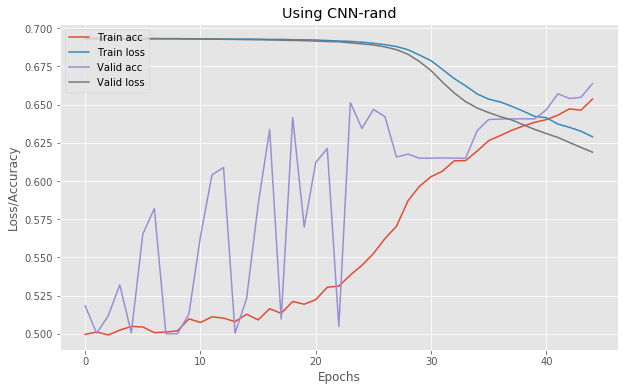

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_acc'])
plt.plot(model.history.history['val_loss'])
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using '+ model_type)
# imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
# plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()

### Continue from a pretrained model

In [17]:
import pickle

# filename = './newtrain_CNN-rand_2017-04-08_16:29:11'
model = keras.models.load_model(filename + '.h5')

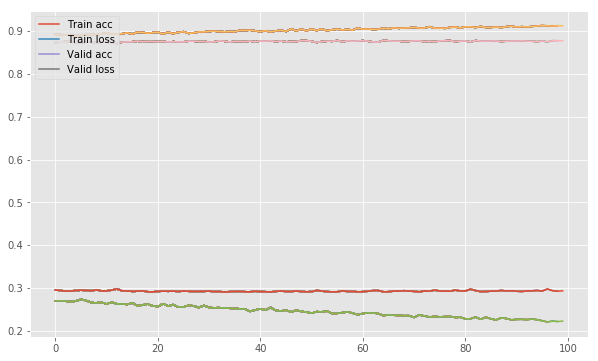

129s - loss: 0.2236 - acc: 0.9115 - val_loss: 0.2941 - val_acc: 0.8767


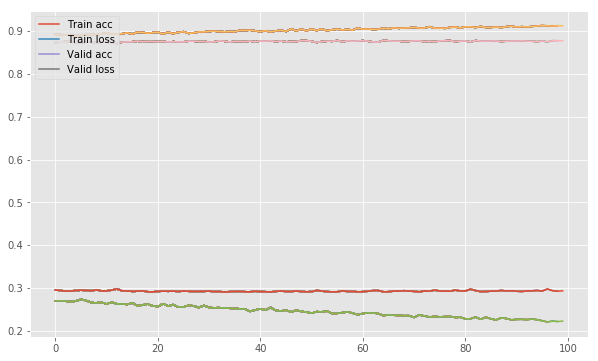

In [18]:
histories = Histories()
model.compile(loss="binary_crossentropy", optimizer=optimizers.SGD(0.005), metrics=["accuracy"])

res = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=100,
          validation_data=(x_test, y_test), verbose=2, callbacks=[histories])

### Save the model (marking as continued)

In [19]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = './newbinary_continued_' + model_type + '_' + date + '_' +time

with open( filename + '_history', 'wb') as output:
    pickle.dump([model.history.history], output, pickle.HIGHEST_PROTOCOL)
    
model.save(filename + '.h5')

In [16]:
import os
os.system('say done')

32512

In [28]:
files = [
'newbinary_CNN-rand_2017-04-10_17:35:55_history',
'newbinary_continued_CNN-rand_2017-04-11_01:18:18_history',
'newbinary_continued_CNN-rand_2017-04-11_13:04:39_history'
]

In [29]:
train_acc, train_loss, val_acc, val_loss = [],[],[],[]

for file in files:
    with open( file, 'rb') as input:
        out = pickle.load(input)
    train_acc += out[0]['acc']
    train_loss += out[0]['loss']
    val_acc += out[0]['val_acc']
    val_loss += out[0]['val_loss']

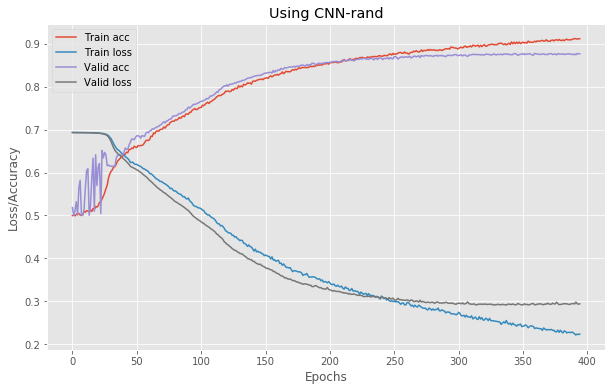

In [32]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(train_acc)
plt.plot(train_loss)
plt.plot(val_acc)
plt.plot(val_loss)
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using '+ model_type)
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]
imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()